# Calculating Garman–Kohlhagen for FX Options

## Imports

In [210]:
# Numpy & Scipy
import numpy as np
from scipy.stats import norm
from datetime import datetime, date
import pandas_datareader as reader
import math

### Garman–Kohlhagen Equations

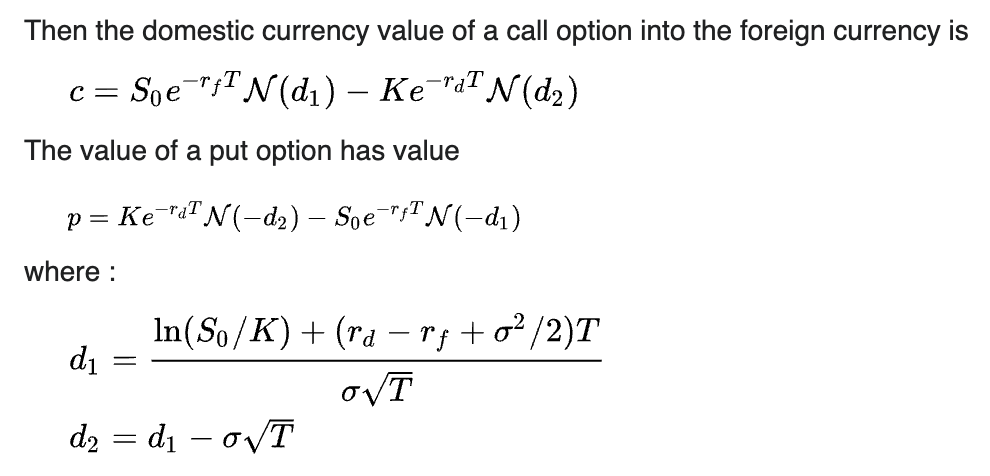

### Garman–Kohlhagen Helper Functions

In [211]:
# Calcuating d1 of Black Scholes Equation
def d1(S, K, rd, rf, T, sigma):
    return ((np.log(S/K) + (rd - rf + (sigma ** 2)/2) * t)) / (sigma * np.sqrt(T))

# Calcuating d2 of Black Scholes Equation
def d2(S, K, rd, rf, T, sigma):
    return d1(S, K, rd, rf, T, sigma) - sigma * np.sqrt(T)
       
# Call Option Black Scholes Equation
def gkc(S, K, rd, rf, T, sigma):
    return S * norm.cdf(d1(S, K, rd, rf, T, sigma)) - K * math.exp(-rd * T) * norm.cdf(d2(S, K, rd, rf, T, sigma))

# Put Option Black Scholes Equation
def gkp(S, K, rd, rf, T, sigma):
    return K * math.exp(-rd * T) * norm.cdf(-1 * d2(S, K, rd, rf, T, sigma)) - S * math.exp(-rf * T) * norm.cdf(-1 * d1(S, K, rd, rf, T, sigma))

### Garman–Kohlhagen Function

In [212]:
# S is the current spot rate
# K is the strike price
# rd is domestic risk free simple interest rate
# rf is foreign risk free simple interest rate
# T is the time to maturity (calculated according to the appropriate day count convention) 
# sigma is the volatility of the FX rate
# flag 'c' or 'p' for call or put

# GK FX Exchange Option's Pricing Model
def garman_kohlhagen(S, K, rd, rf, T, sigma, flag = "c"):
    if flag == "c":
        price = gkc(S, K, rd, rf, T, sigma)
        
    elif flag == "p":
        price = gkp(S, K, rd, rf, T, sigma)

    return price

### Gathering Historical Data on Underlying Currency

In [234]:
# DEXUSEU is U.S. Dollars to Euro Spot Exchange Rate
pair = 'DEXUSEU'
expiry = '12-21-2023'
strike = 1.1250

# Pulling FX Exchange data from Federal Reserve Bank of St. Louis
df = reader.DataReader(pair, 'fred')
df = df.sort_values(by='DATE')
df = df.dropna()

# Calculating Volatility from historical data
df = df.assign(Previous = df.DEXUSEU.shift(1))
df['Returns'] = ((df.DEXUSEU - df.Previous) / df.Previous)
sigma = np.sqrt(252) * df['Returns'].std() 

# Pulling One Yr. Yield data from Federal Reserve Bank of St. Louis
oneyrUSD = reader.DataReader('DGS1', 'fred').iloc[-1] / 100
oneyrEUR = 3.47 / 100 # Hard Coded
spot = df['DEXUSEU'].iloc[-1]

# Calculating Time to Maturity
today = datetime.now()
one_year_ago = today.replace(year=today.year - 1)
T = (datetime.strptime(expiry, "%m-%d-%Y") - datetime.utcnow()).days / 365

### Calculating Option Price

In [236]:
# Variables for Pricing
print("Spot Price:      ", round(spot, 3))
print("Strike Price:    ", round(strike, 3))
print("1 Yr US Yield %: ", round(oneyrUSD[0] * 100, 3))
print("1 Yr EU Yield %: ", round(oneyrEUR * 100, 3))
print("DTE:             ", round(T, 3))
print("Sigma:           ", round(sigma, 3))

print("Option Price:    ", round(garman_kohlhagen(spot, strike, oneyrUSD[0], oneyrEUR, T, sigma, "c"), 3))

Spot Price:       1.088
Strike Price:     1.125
1 Yr US Yield %:  5.24
1 Yr EU Yield %:  3.47
DTE:              0.079
Sigma:            0.073
Option Price:     0.036
